# Yelp Dataset Challenge

Using data from the [Yelp Dataset Challenge](http://www.yelp.com/dataset_challenge/), demonstrate some data exploration and ideas for modeling.

|file                               | type     |SizeMB| Records|
|:----------------------------------|:---------|-----:|-------:|
|yelp_academic_dataset_business.json| business |   53 |  61184 |
|yelp_academic_dataset_checkin.json | checkin  |   20 |  45166 |
|yelp_academic_dataset_review.json  | review   | 1300 |1569264 |
|yelp_academic_dataset_tip.json     | tip      |   94 | 495107 |
|yelp_academic_dataset_user.json    | user     |  158 | 366715 |



## Potential applications of machine learning

### Friends of friends and friends with common interests

Friends could be recommended to users based on their existing social networks on the theory that friends of friends are likely to acquainted. This could be presented to the users as "people you may know" as is done in other social networks like Facebook and Linked-In. The use of [community detection algorithms](http://arxiv.org/abs/0908.1062) might prove interesting as well.

The associations with businesses, categories of businesses, and ratings also offers the possibility of recommending users to follow based on common interests and geographic area.

### Recommendation of businesses to users

Reviews, checkins and tips relate users to businesses. This information could be used to suggest specific businesses that a user may want to check out and potentially review based on a nearest-neighbors similarity to other businesses that the user has interacted with previously.

For example, if a user reviewed or checked-in at several dive bars in Seattle, that user may be able to review other dive bars in the same area.

### Recommendation of users to businesses

Businesses benefit from positive reviews and from feedback in general. It might be interesting to try to recommend users to businesses, either for promotions, advertising or directly soliciting them to "tell us what you think" via Yelp review.

### Natural language processing

The data set contains a corpus of reviews labeled by users as being useful, funny, or cool and tips that can be 'liked'. This labeled data along with natural language processing derived features such as bag-of-words or word-to-vec could be used to predict the attributes of a review before they're labeled by users and surface quality content sooner. Similar techniques could also be used to spot spam and abusive content.


## Data Exploration

In this section, we'll explore the data and get familiar with some of it's properties.

In [1]:
from __future__ import print_function
from collections import Counter
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "/Users/CBare/Documents/projects/Yelp Dataset Challenge/yelp_dataset_challenge_academic_dataset"

In [3]:
import json, os
users = []
with open(os.path.join(data_dir, 'yelp_academic_dataset_user.json')) as f:
    for line in f:
        users.append(json.loads(line))
print("Read {count} users".format(count=len(users)))

Read 366715 users


In [4]:
reviews = []
with open(os.path.join(data_dir, 'yelp_academic_dataset_review.json')) as f:
    for line in f:
        reviews.append(json.loads(line))
print("Read {count} reviews".format(count=len(reviews)))

Read 1569264 reviews


In [5]:
businesses = []
with open(os.path.join(data_dir, 'yelp_academic_dataset_business.json')) as f:
    for line in f:
        businesses.append(json.loads(line))
print("Read {count} businesses".format(count=len(businesses)))

Read 61184 businesses


## Distribution of Friends

Slightly over half of users in the data set have not defined any friends in Yelp. The distribution of number of friends follows a powerlaw distribution.

In [6]:
friend_counts = []
for user in users:
    friend_counts.append(len(user["friends"]))
print("Counted {count} friend relationships".format(count=sum(friend_counts)))

Counted 2576179 friend relationships


In [7]:
print("Fraction of users with no defined friends: %0.3f" % 
      (len([c for c in friend_counts if c==0]) / float(len(friend_counts))))

Fraction of users with no defined friends: 0.525


In [8]:
nonzero_friend_counts = [c for c in friend_counts if c>0]

In [9]:
def summary(data):
    print("n    = {n}\n"
          "mean = {mean}\n"
          "sd   = {sd}\n"
          "min  = {min}\n"
          "10%  = {p10}\n"
          "25%  = {p25}\n"
          "50%  = {p50}\n"
          "75%  = {p75}\n"
          "90%  = {p90}\n"
          "max  = {max}".format(
            n=len(data),
            min=min(data),
            p10=np.percentile(data, 10),
            p25=np.percentile(data, 25),
            p50=np.percentile(data, 50),
            p75=np.percentile(data, 75),
            p90=np.percentile(data, 90),
            mean=np.mean(data),
            sd=np.std(data),
            max=max(data)))
summary(nonzero_friend_counts)

n    = 174094
mean = 14.7976323136
sd   = 56.9098133599
min  = 1
10%  = 1.0
25%  = 1.0
50%  = 4.0
75%  = 10.0
90%  = 29.0
max  = 3830


Code to fit to a powerlaw adapted from the [SciPy Cookbook's section on Fitting Data](http://scipy-cookbook.readthedocs.org/items/FittingData.html?highlight=powerlaw).


In [10]:
def powerlaw(p, x):
    return p[0] * (x**p[1])

def fitfunc(p,x):
    return p[0] + p[1] * x 

def errfunc(p, x, y):
    return (y - fitfunc(p, x))/ (fitfunc(p, x)+1)

def fit_to_powerlaw(xs,ys):
    logx = np.log10(np.maximum(np.ones(len(xs)),xs))
    logy = np.log10(np.maximum(np.ones(len(ys)),ys))
    pinit = [max(ys), -1.0]
    out = optimize.leastsq(errfunc, pinit, args=(logx, logy), full_output=1)
    pfinal = out[0]
    index = pfinal[1]
    amp = 10.0**pfinal[0]
    return (amp, index)


p= (1862027170.1582437, -2.6012503669386793)


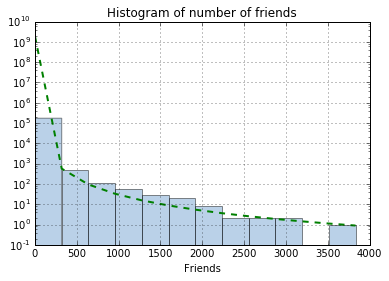

In [11]:
y, bins, patches = plt.hist(nonzero_friend_counts, 12, log=True, facecolor='#6699cc', alpha=0.45)

p = fit_to_powerlaw(bins[:-1], y)
print("p=",p)
plt.plot(bins, powerlaw(p, bins), 'g--', lw=2)

plt.xlabel('Friends')
plt.title('Histogram of number of friends')
plt.grid(True)
plt.show()

## Distribution of Reviews per user

The 366,715 users in the data set contributed over 11.8 million reviews of which we are given almost 1.6 million.

In [12]:
user_review_count = {}
for review in reviews:
    user_id = review["user_id"]
    if user_id in user_review_count:
        user_review_count[user_id] += 1
    else:
        user_review_count[user_id] = 1
summary(user_review_count.values())

n    = 366715
mean = 4.27924682655
sd   = 15.0659659631
min  = 1
10%  = 1.0
25%  = 1.0
50%  = 1.0
75%  = 3.0
90%  = 8.0
max  = 1427


In [13]:
summary([user['review_count'] for user in users])

n    = 366715
mean = 32.214809866
sd   = 94.8369353023
min  = 0
10%  = 1.0
25%  = 2.0
50%  = 6.0
75%  = 21.0
90%  = 74.0
max  = 8843


In [14]:
sum([user['review_count'] for user in users])

11813654

In [15]:
sum(user_review_count.values())

1569264

**Note**: There appears to be a discrepency in the counts of reviews, if my understanding of the data is correct. While we are not given all the reviews for the users included in the data set, we should not have more reviews in hand than the *review_count* field for a given user, but we do see this for over 3 thousand users. Please clarify before relying on the analysis that follows.

In [16]:
len([user['user_id'] for user in users if user_review_count[user['user_id']] > user['review_count']])

3072

p= (392498.89197962644, -1.1635921908941222)


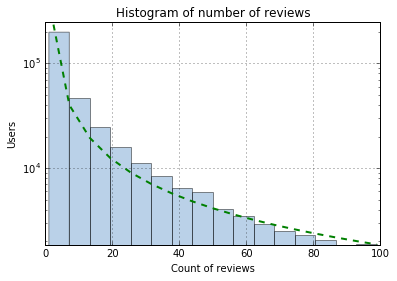

In [17]:
review_counts = [user['review_count'] for user in users if user['review_count']>0 and user['review_count']<100]
y, bins, patches = plt.hist(review_counts, 16, log=True, facecolor='#6699cc', alpha=0.45)

p = fit_to_powerlaw(bins[:-1], y)
print("p=",p)
plt.plot(bins, powerlaw(p, bins), 'g--', lw=2)

plt.xlabel('Count of reviews')
plt.ylabel('Users')
plt.title('Histogram of number of reviews')
plt.grid(True)
plt.axis([0, 100, 0, 250000])
plt.show()

In [18]:
len([user['review_count'] for user in users if user['review_count']>100])

27935

### Elite users


In [19]:
review_count_by_elite_years = []
for i in range(12):
    review_count_by_elite_years.append([])
for user in users:
    elite_years = len(user['elite'])
    review_count_by_elite_years[elite_years].append(user['review_count'])

In [20]:
elite = sum(len(review_count_by_elite_years[i]) for i in range(1,len(review_count_by_elite_years)))
print("Of %d users, %d or %0.1f%% have at some time qualified for elite status." % (len(users), elite, float(elite)/float(len(users))*100.0))

Of 366715 users, 25301 or 6.9% have at some time qualified for elite status.


In [21]:
for elite_years in range(len(review_count_by_elite_years)):
    print("%2d %8.1f" % (elite_years, np.mean(review_count_by_elite_years[elite_years])))

 0     16.4
 1    118.0
 2    146.0
 3    205.7
 4    278.9
 5    357.0
 6    454.8
 7    563.7
 8    715.1
 9    780.1
10   1081.4
11   1702.9


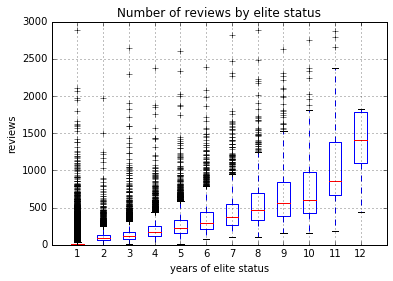

In [22]:
plt.boxplot(review_count_by_elite_years)
plt.axis([0,13,0,3000])
plt.ylabel('reviews')
plt.xlabel('years of elite status')
plt.title('Number of reviews by elite status')
plt.grid(True)
plt.show()

## Ratings

People seem to review things they like. The distribution of ratings is heavily skewed towards 4 and 5 stars.

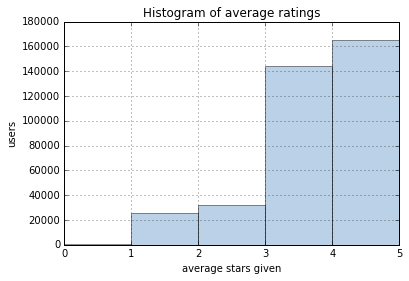

In [23]:
average_stars = [user['average_stars'] for user in users]
y, bins, patches = plt.hist(average_stars, 5, facecolor='#6699cc', alpha=0.45)

plt.xlabel('average stars given')
plt.ylabel('users')
plt.title('Histogram of average ratings')
plt.grid(True)
#plt.axis([0, 100, 0, 250000])
plt.show()

## Graph Analysis

The following is the beginnings of a system for recommending potential friends in the Yelp dataset.

In [24]:
from graphlab import SGraph, Vertex, Edge

In [25]:
vertices = []
for user in users:
    vertices.append(Vertex(user['user_id'], attr={
                'name': user['name'],
                'review_count': user['review_count'],
                'average_stars': user['average_stars'],
                'funny': user['votes']['funny'],
                'useful': user['votes']['useful'],
                'cool': user['votes']['cool']
            }))

In [26]:
edges = []
for user in users:
    edges.extend([Edge(user['user_id'], friend_id) for friend_id in user['friends']])

In [27]:
g = SGraph(vertices=vertices, edges=edges)

[INFO] 1452577171 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_FILE to /usr/local/lib/python2.7/site-packages/certifi/cacert.pem
1452577171 : INFO:     (initialize_globals_from_environment:282): Setting configuration variable GRAPHLAB_FILEIO_ALTERNATIVE_SSL_CERT_DIR to 
This trial license of GraphLab Create is assigned to christopherbare+yoyodyne@gmail.com and will expire on February 10, 2016. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-23043 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1452577171.log
[INFO] GraphLab Server Version: 1.7.1


In [28]:
g.summary()

{'num_edges': 2576179, 'num_vertices': 366715}

In [29]:
import graphlab
cc = graphlab.connected_components.create(g, verbose=True)
print("Connected components summary:\n", cc.summary())

PROGRESS: +-----------------------------+
PROGRESS: | Number of components merged |
PROGRESS: +-----------------------------+
PROGRESS: | 171730                      |
PROGRESS: | 0                           |
PROGRESS: +-----------------------------+
Class                                   : ConnectedComponentsModel

Graph
-----
num_edges                               : 2576179
num_vertices                            : 366715

Results
-------
graph                                   : SGraph. See m['graph']
component size                          : SFrame. See m['component_size']
number of connected components          : 195049
vertex component id                     : SFrame. See m['componentid']

Metrics
-------
training time (secs)                    : 2.5834

Queryable Fields
----------------
graph                                   : A new SGraph with the color id as a vertex property
component_id                            : An SFrame with each vertex's component id
component_size

In [30]:
cc_size = cc['component_size'].sort('Count', ascending=False)
print(cc_size)

+--------------+--------+
| component_id | Count  |
+--------------+--------+
|    12825     | 168923 |
|    59419     |   8    |
|    112427    |   6    |
|     3001     |   5    |
|    116536    |   5    |
|    180267    |   5    |
|    121022    |   5    |
|    162518    |   5    |
|    124689    |   5    |
|    125091    |   5    |
+--------------+--------+
[195049 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [31]:
cc_out = cc['component_id']
tgt = cc_size['component_id'][1]
tgt_ids = cc_out[cc_out['component_id'] == tgt]['__id']

subgraph = graphlab.SGraph()
subgraph = subgraph.add_vertices(g.get_vertices(tgt_ids))
subgraph = subgraph.add_edges(g.get_edges(src_ids=tgt_ids),
                              src_field='__src_id', dst_field='__dst_id')
graphlab.canvas.set_target('ipynb')
subgraph.show(vlabel='name')

In [70]:
tgt = cc_size['component_id'][0]
tgt_ids = cc_out[cc_out['component_id'] == tgt]['__id']
neighborhood = g.get_neighborhood(tgt_ids[112], 2)
neighborhood.summary()

{'num_edges': 126, 'num_vertices': 48}

In [71]:
neighborhood.show(vlabel='name')

In the above examples, it might be helpful to suggest connections between the people separated by short paths in the network.